<a href="https://colab.research.google.com/github/inder-dev-pro/Multi-Agent-Business-Analyst/blob/main/Startup_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import pandas as pd
import plotly.figure_factory as ffdemo
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
# Download latest version
path = kagglehub.dataset_download("yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


100%|██████████| 2.82M/2.82M [00:00<00:00, 111MB/s]

Extracting files...


In [ ]:
print("Path to dataset files:", path)
df=pd.read_csv(path+ r"/big_startup_secsees_dataset.csv")
df.head(5)
print(df.nunique())
print(df['status'].value_counts())
df.dropna(subset=['funding_total_usd'], inplace=True)

Path to dataset files: /root/.cache/kagglehub/datasets/yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase/versions/1
permalink            66368
name                 66102
homepage_url         61191
category_list        27296
funding_total_usd    18896
status                   4
country_code           137
state_code             311
region                1092
city                  5111
funding_rounds          19
founded_at            3978
first_funding_at      4817
last_funding_at       4518
dtype: int64
status
operating    53034
closed        6238
acquired      5549
ipo           1547
Name: count, dtype: int64


In [ ]:
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df['first_funding_at']=pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at']=pd.to_datetime(df['last_funding_at'], errors='coerce')
df['founded_at']=pd.to_datetime(df['founded_at'], errors='coerce')



```
# Dividing the data into Train, Test and Val
```



In [ ]:
one_hot_encoding=OneHotEncoder()
one_hot_encoding.fit(df[['status']])
feature_names=one_hot_encoding.get_feature_names_out(['status'])
status_encoded=one_hot_encoding.transform(df[['status']]).toarray()
status_encoded_df=pd.DataFrame(status_encoded, columns=feature_names)
df=pd.concat([df,status_encoded_df], axis=1)

In [ ]:
scaler=MinMaxScaler()
df[['funding_total_usd', 'funding_rounds']]=scaler.fit_transform(df[['funding_total_usd', 'funding_rounds']])

In [ ]:
target_encoder=TargetEncoder()
df[['country_code']]=target_encoder.fit_transform(df['country_code'], df['status'])

In [ ]:
vocab_size=27297
embedding_size=16
label_encoder=LabelEncoder()
embeddings=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_size)
df['category_index']=label_encoder.fit_transform(df['category_list'])
category_indices=tf.convert_to_tensor(df['category_index'], dtype=tf.int32)
embedded_values=embeddings(category_indices)
embedded_values=tf.keras.layers.Flatten()(embedded_values)
embedded_values.numpy()

array([[ 0.04963969, -0.04760485,  0.03508446, ...,  0.00338667,
        -0.02289896, -0.01942136],
       [ 0.00901521, -0.01478888, -0.027748  , ..., -0.02015941,
         0.02186579,  0.01976408],
       [ 0.01172937,  0.0165434 ,  0.04839161, ..., -0.03861772,
         0.0149063 , -0.01222441],
       ...,
       [-0.00023188, -0.01596021, -0.03195675, ..., -0.04846048,
        -0.04579773, -0.0066369 ],
       [-0.00980134,  0.04221464, -0.02778782, ..., -0.04693271,
        -0.02331768, -0.00240954],
       [ 0.0073545 ,  0.03847529, -0.02919221, ...,  0.04940227,
        -0.00585549,  0.02024892]], dtype=float32)

In [ ]:
train_val_data, test_data=train_test_split(df,test_size=0.2, random_state=42)
train_data, val_data=train_test_split(train_val_data, test_size=0.25, random_state=42)
input_cols = ['funding_total_usd', 'funding_rounds', 'first_funding_years', 'last_funding_years', 'country_code']
target_cols=[ 'status_acquired', 'status_closed', 'status_ipo', 'status_operating']

In [ ]:
numerical_cols=df.select_dtypes(include=np.number).columns.to_list()
categorical_cols=df.select_dtypes(include=object).columns.to_list()

In [ ]:
# Convert date columns to numerical format (Elapsed years from founding)
def convert_dates(df):
    df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
    df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
    df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')

    # Calculate elapsed years since founding
    df['first_funding_years'] = (df['first_funding_at'] - df['founded_at']).dt.days / 365.0
    df['last_funding_years'] = (df['last_funding_at'] - df['founded_at']).dt.days / 365.0

    # Fill NaNs with 0
    df[['first_funding_years', 'last_funding_years']] = df[['first_funding_years', 'last_funding_years']].fillna(0)

    return df

# Apply function
train_data = convert_dates(train_data)
val_data = convert_dates(val_data)
test_data = convert_dates(test_data)

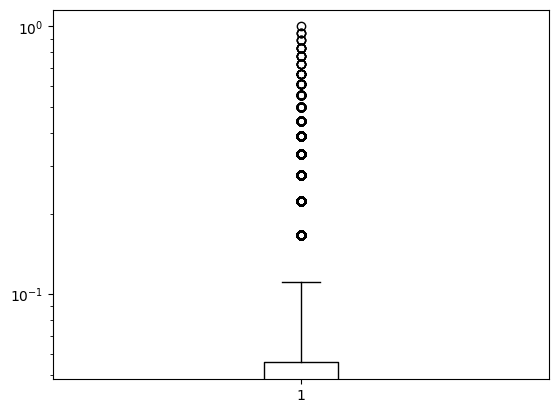

In [ ]:
plt.boxplot(x=df['funding_rounds'])
plt.yscale('log')
plt.show()



```
Converting the status(Target col) into a Numeric Column
```



In [ ]:
outlier=[]
def outlier_detection(data):
  threshold=4
  mean=np.mean(data)
  std=np.std(data)

  for i in data:
    if ((i-mean)/std>3):
      outlier.append(i)

  return outlier
out=outlier_detection(df.funding_rounds)

outlier_df_z=pd.DataFrame(out, columns=["Funding_Round_Outlier"])
outlier_df_z

,Funding_Round_Outlier
0,0.444444
1,0.277778
2,0.444444
3,0.333333
4,0.277778
...,...
1725,0.388889
1726,0.277778
1727,0.388889
1728,0.333333


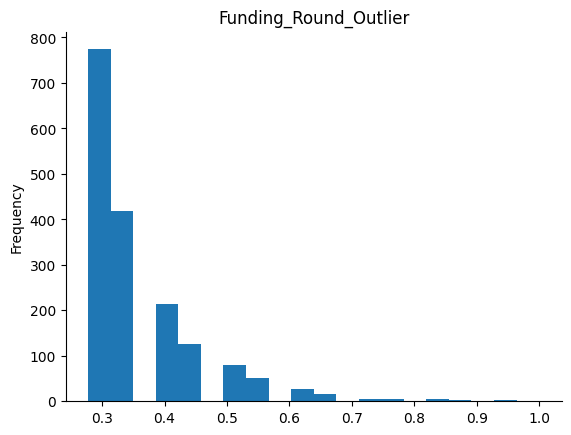

In [ ]:
from matplotlib import pyplot as plt
outlier_df_z['Funding_Round_Outlier'].plot(kind='hist', bins=20, title='Funding_Round_Outlier')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
iqr_outlier_list=[]
def IQR(data):
  q1,q3=np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=q1-((iqr)*1.5)
  upper_bound=q3+((iqr)*1.5)
  for i in data:
    if (i<lower_bound or i>upper_bound):
      iqr_outlier_list.append(i)
  return iqr_outlier_list
iqr_out=IQR(df.funding_rounds)

outlier_df_iqr=pd.DataFrame(iqr_out,columns=["Outlier_using_IQR"])
outlier_df_iqr

,Outlier_using_IQR
0,0.166667
1,0.166667
2,0.444444
3,0.222222
4,0.277778
...,...
5932,0.166667
5933,0.166667
5934,0.166667
5935,0.166667


Using Min Max Scaler for Numeric Cols to be used for model training

Target Encoding for Country Code

This is to convert high cardinality categorical data into numerical columns

Defining inputs and outputs for the keras model

In [ ]:
X_train = [train_data[input_cols].values.astype(np.float32), train_data['category_index'].values.reshape(-1, 1)]
y_train = train_data[target_cols].values.astype(np.float32)

X_val = [val_data[input_cols].values.astype(np.float32), val_data['category_index'].values.reshape(-1, 1)]
y_val = val_data[target_cols].values.astype(np.float32)

In [ ]:
category_input = Input(shape=(1,), name='category_input')  # Categorical Feature
num_input = Input(shape=(5,), name='num_input')  # 5 Numerical Features (Fixing Shape)

Building a FeedForward Neural Network Model

In [ ]:
merged = Concatenate()([category_input, num_input])
x = Dense(64, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax', name="output")(x)
model = Model(inputs=[category_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ category_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6)              │              0 │ category_input[0][0],  │
│                           │                        │                │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            448 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 4)              │             68 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,124 (12.20 KB)

 Trainable params: 3,124 (12.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=32, validation_data=(X_val, y_val)
)

Epoch 1/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.0830 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 2/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0828 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 3/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0842 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 4/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0841 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 5/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0847 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 6/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0854 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 7/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0820 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 8/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0837 - loss: nan - val_accuracy: 0.0823 - val_loss: nan
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(
    [test_data['category_index'].values, test_data[input_cols].values],
    test_data[['status_operating', 'status_closed', 'status_acquired', 'status_ipo']].values
)
print(f"Test Accuracy: {test_acc:.4f}")

415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7965 - loss: nan
Test Accuracy: 0.7925


In [ ]:
print(df.first_funding_at)
df.nunique()
df.isnull().sum()
df.isna().sum()
df.info()
input_cols
numerical_cols

0       2015-01-05
1       2014-03-01
2       2014-01-30
3       2008-03-19
4       2014-07-24
           ...    
66363   2012-04-01
66364   2011-11-01
66365   2014-08-01
66366   2015-01-01
66367   2013-10-01
Name: first_funding_at, Length: 66368, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   permalink          66368 non-null  object        
 1   name               66367 non-null  object        
 2   homepage_url       61310 non-null  object        
 3   category_list      63220 non-null  object        
 4   funding_total_usd  53583 non-null  float64       
 5   status             66368 non-null  object        
 6   country_code       66368 non-null  float64       
 7   state_code         57821 non-null  object        
 8   region             58338 non-null  object        
 9   city       

['funding_total_usd',
 'country_code',
 'funding_rounds',
 'status_acquired',
 'status_closed',
 'status_ipo',
 'status_operating',
 'category_index']

In [ ]:
# Save the model
model.save("startup_prediction_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
new_data = {
    "funding_total_usd": [5000000],   # Example: $5M in funding
    "funding_rounds": [3],
    "last_funding_years": [5.0],
    "country_code": [0.75],
    "category_index": [15]
}

# ✅ Convert Data to NumPy Arrays
X_numerical = np.array([new_data["funding_total_usd"],
                         new_data["funding_rounds"],
                         new_data["last_funding_years"],
                         new_data["country_code"]]).T.astype(np.float32)

X_category = np.array(new_data["category_index"]).reshape(-1, 1).astype(np.int32)
# Evaluate model to check if it's working
test_loss, test_acc = model.evaluate([X_numerical,X_category], np.array([[1, 0, 0, 0]]))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# ✅ Make Prediction
predictions =model.predict([X_numerical, X_category])

# ✅ Convert to Class Label
status_classes = ["operating", "closed", "acquired", "ipo"]
predicted_index = np.argmax(predictions, axis=1)[0]

# ✅ Print Final Prediction
print("Predicted Startup Status:", predictions)

(39820, 21)

In [ ]:
!git init
!git remote add origin https://github.com/inder-dev-pro/EDA-Mark_Keith.git
!git branch -m main
!git add .
!git status
!git commit -m "Initial Upload"
!git config --global user.email "inder.31ssb.com"
!git config --global user.name "inder-dev-pro"
!git push origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
On branch main

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)
	new file:   .config/.last_opt_in_prompt.yaml
	new file:   .config/.last_survey_prompt.yaml
	new file:   .config/.last_update_check.json
	new file:   .config/active_config
	new file:   .config/config_sentinel
	new file:   .config/configurations/config_default
	new file:   .config/default_configs.db
	new file:   .config/gce
	new file:   .config/hidden_gcloud_